# Developing Pyreal Applications

In this tutorial, we will be going through the process of putting together a RealApp object for future use.

If you have not already tried Demonstration 1: Using Pyreal, please do so before trying this demo, to better understand the purpose of RealApp objects.

## Scenario Details
### Goals for this Scenario
1. Learn the components of a Pyreal RealApp, and the steps required to create one for your target application
2. Learn about Pyreal's built-in Transformers, and how to make custom, application-specific transformers

### User Details

- **User Role:** ML Engineer for Real Estate Firm
- **Expertise:**
    - **Domain (House Pricing):** Some experience
    - **Machine Learning:** Expert
    - **Explainable ML techniques:** Basic understanding
- **User Goals:**
    1. Understand what features contribute to average block prices in California

### Model and Data Details
- 9 Features
- Predicts average price of block of houses

## Data Loading

We will begin by loading in our data matrix and targets, and taking a look at the data


In [1]:
from pyreal.sample_applications import california_housing
import pandas as pd

X, y = california_housing.load_data()
X.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12058,-117.59,33.88,13,3239,849.0,2751,813,2.6111,INLAND
7699,-118.12,33.96,36,1426,235.0,698,240,4.8523,<1H OCEAN
8696,-118.34,33.86,35,1936,343.0,1008,346,5.4791,<1H OCEAN
4134,-118.22,34.13,52,791,174.0,501,162,3.3542,<1H OCEAN
2073,-119.83,36.76,15,3291,772.0,1738,634,1.9760,INLAND


## Explaining Without Pyreal
Let's start by fitting some transformers, training a model, and trying to generate a global explanation of our model without using Pyreal, so we have a point of comparison for both coding effort and explanation quality over just using ML and explanation algorithms directly.

First, we transform the data and train a basic Perceptron...

In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_transform = X.copy()

# One-hot encode ocean_proximity to be compatible with model
ohe = OneHotEncoder(sparse_output=False)
ohe_cols = ohe.fit_transform(X_transform[["ocean_proximity"]])
ohe_cols_df = pd.DataFrame(ohe_cols)
column_names = ohe.get_feature_names_out(["ocean_proximity"])
ohe_cols_df.columns = column_names
X_transform = X_transform.drop("ocean_proximity", axis="columns")
X_transform = pd.concat([X_transform, ohe_cols_df], axis=1)

# Impute data to be compatible with model
imp = SimpleImputer(strategy="mean")
imputed_bedrooms = imp.fit_transform(X_transform[["total_bedrooms"]])
X_transform["total_bedrooms"] = imputed_bedrooms

# Add additional columns
X_transform["average_rooms"] = X_transform["total_rooms"] / X_transform["households"]
X_transform["average_bedrooms"] = X_transform["total_bedrooms"] / X_transform["households"]

columns = X_transform.columns

# Scale data to improve model performance
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, random_state=1)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns) # We use DataFrame here to maintain feature names (column names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

# Train model
model = MLPRegressor(hidden_layer_sizes=(50, 50),
                     max_iter=1000, solver="lbfgs", alpha=0.001).fit(X_train, y_train)
print("R^2 Score:", model.score(X_test, y_test))

R^2 Score: 0.7900165462251842


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


... And then we can use SHAP to generate a beeswarm plot explanation of the data

Permutation explainer: 501it [00:14, 11.35it/s]                         


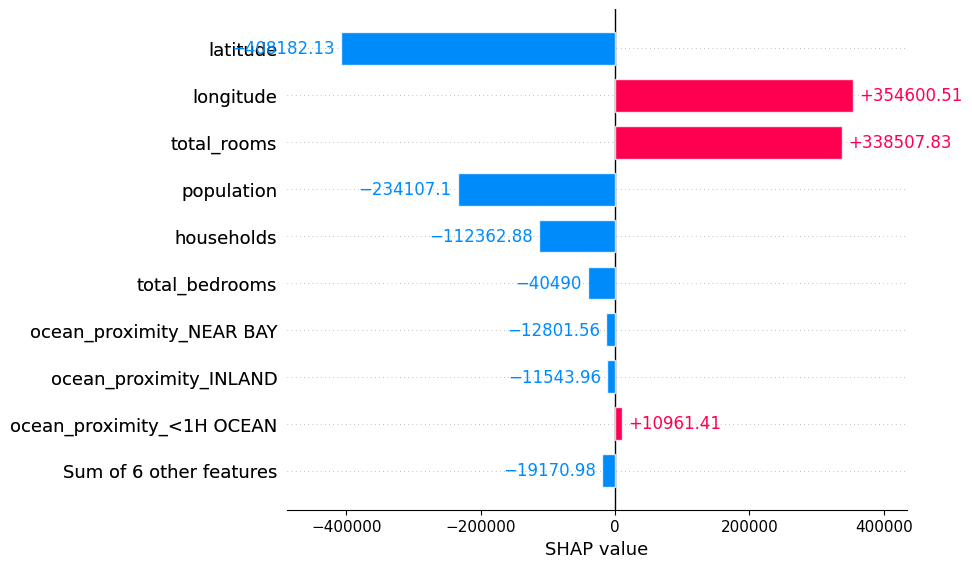

In [51]:
import shap

explainer = shap.Explainer(model.predict, X_train[0:500])
shap_values = explainer(X_train[0:500])
shap.plots.bar(shap_values[0])

Here, each point represents a row in our dataset. The farther right a point is, the more that specific feature value in that row *increased* the model prediction. The farther left a point is, the more that specific feature value in that row *decreased* the model prediction. The points are colored by feature value, with blue points representing a higher value.

For example, we can see from this plot that higher latitudes and longitudes correspond to higher house prices. Similarly, blocks with fewer total rooms or higher populations are more expensive.

## Developing Pyreal Applications: Model Transformers
Often, data needs to be transformed before being passed into a machine learning model, either to improve performance or to format it to be supported by the model architecture. For example, in the code cells above we had to one-hot encode, impute, and standardize our data in order to make model predictions on it.

Unfortunately, these kinds of transformation can make explanations hard to parse. For example, in the explanation above, we need to consider every `ocean_proximity` child feature together to get the total contribution of the actual block proximity to the ocean. Additionally, values are given are standardized values, which is difficult to parse.

By replacing these transformers with the Pyreal built-in equivalents, our explanations will be automatically presented with these muddling transformations undone. Additionally, Pyreal the Pyreal  DataFrameWrapper transformer can remove the need to manually keep track of column names, and the `MultiTypeImputer` transformer automatically imputes all columns with an appropriate strategy.

In [54]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, DataFrameWrapper

# Initialize and fit transformers using fit_transformers
transformers = [MultiTypeImputer(),
                OneHotEncoder(columns="ocean_proximity"),
                DataFrameWrapper(StandardScaler())]

While Pyreal offers many common transformer types, sometimes our specific domains may require a more specific transformer option. Luckily, Pyreal makes it easy to add new *custom transformers*. Let's start with a basic one.

Below, we define the `PerHouseHoldAverager`. Pyreal Transformers extend the base `Transformer` class (line 3). They then define, at minimum, a `data_transform` function. This function acts just like the `.transform()` function of the sklearn transformers we used above - it takes in a dataframe, and returns the dataframe with one or more features transformed. In this case, our transformer adds a new column, with the per-household average of the requested features.

In [55]:
from pyreal.transformers import Transformer

class PerHouseholdAverager(Transformer):
    def __init__(self, columns, **kwargs):
        """
        Args:
            columns (list of strings)
                The names of the columns to average
        """
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        """
        Transform the data by adding a new column from total_[column] called average_[column].
        This feature represents the average value of [column] per household.

        Args:
            x (DataFrame)
                The data to transform
        """
        for column in self.columns:
            name = column.replace("total", "average")
            x[name] = x[column] / x["households"]
        return x

Let's go ahead and add that transformer to our list. You may notice the `interpret` flag in our initialization. This flag tells Pyreal that this transformation improves the *interpretability* of the resulting data - or in other words, changes the presentation of the data in such a way that makes it easier to reason about (or at least, not more difficult).

In this case, we are adding features (`average_rooms` and `average_bedrooms`) that we expect will be very easy for our users to reason about, so we do not need to undo this transformation.

In [58]:
transformers.append(PerHouseholdAverager(columns=["total_bedrooms", "total_rooms"], interpret=True))

Sometimes, there may be a way to make the data even more interpretable (ie, easy to reason about) than the original data, but that for whatever reason we do not want to or cannot make this change to the data being fed into the model.

For example, the latitude and longitude features above are hard to reason about for most people. Something like a city or neighborhood name would be better, but trying to one-hot encode every neighborhood in California to feed into the model would be a massive memory drain. Instead, we will continue giving the model the `longitude`/`latitude` features, but we will then transform the *explanation* to use this more interpretable feature.

To do so, we will use another transformer. Take a look at the definition below; we will then walk through it step-by-step

In [59]:
from pyreal.types.explanations.feature_based import AdditiveFeatureImportanceExplanation, AdditiveFeatureContributionExplanation

class CityConverter(Transformer):
    def __init__(self, **kwargs):
        self.cities = california_housing.load_city_data()
        super().__init__(**kwargs)

    def data_transform(self, x):
        """
        Converts latitude/longitude coordinates to closest city name. Note that
        we are using a very rough estimate here, for illustrative purposes, rather than
        a more complicated but accurate nearest neighbor search
        Args:
            x (DataFrame)
                The data to transform
        """
        for index, row in self.cities.iterrows():
            lat = row["Latitude"]
            lon = row["Longitude"]
            x.loc[(x["latitude"] > lat-0.1) & (x["latitude"] < lat+0.1) & (x["longitude"] > lon-0.1) & (x["longitude"] < lon+0.1), "city"] = row["Name"]
        x = x.drop("latitude", axis=1)
        x = x.drop("longitude", axis=1)
        return x

    def transform_explanation_additive_feature_contribution(self, explanation):
        """
        Combines the contributions of the latitude and longitude features for
        additive local feature contribution explanations.
        Args:
            explanation (Explanation object)
                The explanation to transform
        """
        df = explanation.get()  # A DataFrame with one row per instance and one column per feature
        return AdditiveFeatureContributionExplanation(CityConverter.helper_sum_lat_long_columns(df))

    def transform_explanation_additive_feature_importance(self, explanation):
        """
        Combines the importance of the latitude and longitude features for
        additive local feature importance explanations.
        Args:
            explanation (Explanation object)
                The explanation to transform
        """
        df = explanation.get()  # A DataFrame with one row and one column per feature
        return AdditiveFeatureImportanceExplanation(CityConverter.helper_sum_lat_long_columns(df))

    def helper_sum_lat_long_columns(self, explanation):
        """
        In the case of additive contributions or importances, we can combine the latitude and
        longitude explanation contributions by summing to get the city contribution. In this
        case, our implementation is almost identical for both types of explanations
        """
        explanation_transform = explanation.copy()
        explanation_transform["city"] = explanation["longitude"] + explanation["latitude"]
        explanation_transform = explanation_transform.drop("longitude", axis=1)
        explanation_transform = explanation_transform.drop("latitude", axis=1)
        return explanation_transform

[GO THROUGH TRANSFORMER ABOVE STEP-BY-STEP

In [60]:
transformers.append(CityConverter(interpret=True, model=False))

Once again, we use the `interpret` flag to indicate that this transformation makes our data more interpretable. We also add the `model=False` flag, to indicate that we should **not** apply this model when making model predictions.

### Transformer Functions
When defining a custom transformer, you will need to consider three types of functions:
- `data_transform` (*required*): A single function that transforms the data from space A to B.
- `inverse_transform_explanation_XXX` (*optional*): Functions that transform an explanation from space B to A. This type of function only needs to be considered if the transformer is used by the explanation algorithm and leads to the data being more obfuscated/less interpretable (ie, will have the `algorithm` flag set to True and the `interpret` flag set to False)
- `transform_explanation_XXX` (*optional*): Functions that transform an explanation from space A to B. This type of function only needs to be considered if the transformer is used to make data and explanations more interpretable than the algorithm-ready state (ie, will have the `algorithm` flag set to False and the `interpret` flag set to True)

The `transform_explantion` type functions are written per Explanation output type. For this tutorial, we will consider additive local feature contribution and additive global feature importance explanations. At the end of this tutorial, we will consider some special cases.

### Custom Transformer Example 2: City Converter

Now, let's take a look at another custom transformer, this one requiring an explanation transform. This transformer will be used to convert latitude/longitude values into city areas, based on the closest city to the given coordinates.

Again, we will follow the following steps:

1. Define the transformer `__init__()` method, using a `super()` call for the parent `Transformer` class. The function can take optional arguments to configure the transformer. In this case, we will not take in any parameters.
2. Define the `data_transform()` function, which takes an input DataFrame `x` and returns `x` after undergoing the transformation. In this case, we convert long/lat values to nearby cities.
3. Consider which flags we expect to be used with this transformer. In this case, our transformation will be used to make the data more interpretable, but will not be fed into the model, so our flags are `interpret=True` and `algorithm=model=False`. Therefore, the `transform_explanation_XXX` functions will be called, but not the `inverse_transform_explanation` functions.
4. Consider the explanation output types you are interested in. For now, let's consider additive local feature contribution and additive global feature importance explanations. These are explanations that provide an importance weighting to each feature, and where these importances can be meaningfully added together to represent the importance of multiple features. We will need to define `transform_explanation_additive_feature_contribution` and `transform_explanation_additive_feature_importance` functions.


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
         Note that explanation output types are heirarchial, and Pyreal will use the explanation transforms of higher-level types when the lower-level types are not available. For example, if <code>transform_explanation_additive_feature_contribution</code> is not defined, Pyreal will attempt to use <code>transform_explanation_feature_contribution</code>.
    </p>
</div>


In [61]:
from pyreal.transformers import fit_transformers
from pyreal import RealApp

fit_transformers(transformers, X)
realApp = RealApp(model, X_train_orig=X, transformers=transformers)
realApp.predict(X[:10])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [62]:
from pyreal import visualize

explanation = realApp.produce_local_feature_contributions(X.iloc[1])
visualize.plot_top_contributors(explanation[0], select_by="absolute", show=True)

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: MLPRegressor(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000,
             solver='lbfgs')